### This notebook involves the Multi label classification on Toxic comments data.

In [ ]:
!pip install scikit-plot

In [ ]:
# Import required libraries
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate

import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt

Read the dataset:

We are considering the only 1000 comments for this task.

In [ ]:
toxic_comments = pd.read_csv('toxic_comments.csv')

In [ ]:
toxic_comments.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [ ]:
print(f'Toxic comments data contains {toxic_comments.shape[0]} comments & {toxic_comments.shape[1]} features')

Toxic comments data contains 999 comments & 8 features


Let's remove all the records where any row contain a null value or empty string.

In [ ]:
filter = toxic_comments["comment_text"] != ""
toxic_comments = toxic_comments[filter]
toxic_comments = toxic_comments.dropna()

The comment_text column contains text comments. Let's print a random comment and then see the labels for the comments.

In [ ]:
print(toxic_comments["comment_text"][168])

You should be fired, you're a moronic wimp who is too lazy to do research. It makes me sick that people like you exist in this world.


This is clearly a toxic comment. Let's see the associated labels with this comment:

In [ ]:
print("Toxic:" + str(toxic_comments["toxic"][168]))
print("Severe_toxic:" + str(toxic_comments["severe_toxic"][168]))
print("Obscene:" + str(toxic_comments["obscene"][168]))
print("Threat:" + str(toxic_comments["threat"][168]))
print("Insult:" + str(toxic_comments["insult"][168]))
print("Identity_hate:" + str(toxic_comments["identity_hate"][168]))

Toxic:1
Severe_toxic:0
Obscene:0
Threat:0
Insult:1
Identity_hate:0


Let's now plot the comment count for each label. To do so, we will first filter all the label or output columns.

In [ ]:
toxic_comments_labels = toxic_comments[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]]
toxic_comments_labels.head()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0


Using the toxic_comments_labels dataframe we will plot bar plots that show the total comment counts for different labels.

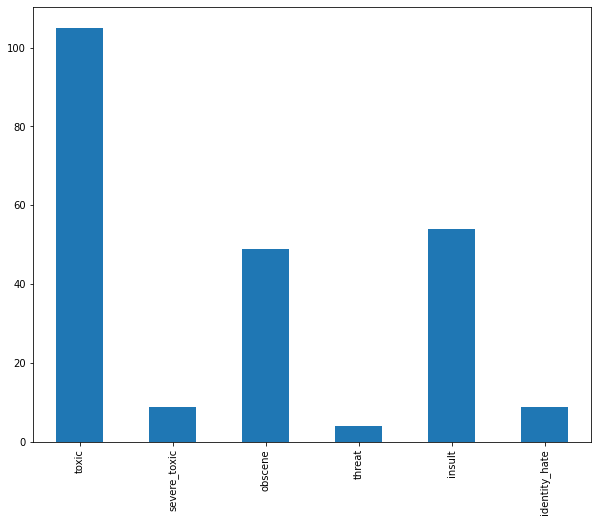

In [ ]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size

toxic_comments_labels.sum(axis=0).plot.bar()

You can see that the "toxic" comment has the highest frequency of occurrence followed by "insult" and "obscene", respectively.

We will create a **multi-label text classification** model where each output label will have a dedicated output dense layer. Let's first define our preprocessing function:

Let's first define our preprocessing function:

In [ ]:
def preprocess_text(sen):
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sen)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

The second step is to create inputs and output for the model. The input to the model will be the text comments, whereas the output will be six labels. The following script creates the input layer and the combined output layer:

In [ ]:
X = []
sentences = list(toxic_comments["comment_text"])
for sen in sentences:
    X.append(preprocess_text(sen))

y = toxic_comments[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]]

Let's divide the data into training and testing sets:

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

The y variable contains the combined output from 6 labels. However, we want to create individual output layer for each label. We will create 6 variables that store individual labels from the training data and 6 variables that store individual label values for the test data.

Look at the following script:

In [ ]:
# First output
y1_train = y_train[["toxic"]].values
y1_test =  y_test[["toxic"]].values

# Second output
y2_train = y_train[["severe_toxic"]].values
y2_test =  y_test[["severe_toxic"]].values

# Third output
y3_train = y_train[["obscene"]].values
y3_test =  y_test[["obscene"]].values

# Fourth output
y4_train = y_train[["threat"]].values
y4_test =  y_test[["threat"]].values

# Fifth output
y5_train = y_train[["insult"]].values
y5_test =  y_test[["insult"]].values

# Sixth output
y6_train = y_train[["identity_hate"]].values
y6_test =  y_test[["identity_hate"]].values

The next step is to convert textual inputs to embedded vectors. The following script does that:

In [ ]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1

maxlen = 200

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

We will be using GloVe word embeddings to convert text inputs to their numeric counterparts.

We are downloading Glove embedding **glove6B.100d.txt** from kaggle.

In [ ]:
from google.colab import files
uploaded_json=files.upload()                  #Upload kaggle API json file

Saving kaggle.json to kaggle.json


Saving kaggle.json to kaggle.json

In [ ]:
!pip install -q kaggle        #install kaggle API

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/         #move kaggle json file to /.kaggle

In [ ]:
!ls                    #list directory

kaggle.json  sample_data  toxic_comments.csv


In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d danielwillgeorge/glove6b100dtxt

 95% 125M/131M [00:03<00:00, 48.1MB/s]
100% 131M/131M [00:04<00:00, 32.1MB/s]


In [ ]:
!unzip \*.zip

Archive:  glove6b100dtxt.zip
  inflating: glove.6B.100d.txt       


In [ ]:
!ls

glove.6B.100d.txt   kaggle.json  toxic_comments.csv
glove6b100dtxt.zip  sample_data


In [ ]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()

glove_file = open('glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

We will creates a model with one input layer, one embedding layer, one LSTM layer with 128 neurons and one output layer with 6 neurons since we have 6 labels in the output.

In [ ]:
deep_inputs = Input(shape=(maxlen,))
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)(deep_inputs)
LSTM_Layer_1 = LSTM(128)(embedding_layer)
dense_layer_1 = Dense(6, activation='sigmoid')(LSTM_Layer_1)
model = Model(inputs=deep_inputs, outputs=dense_layer_1)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

Let's print the model summary:

In [ ]:
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 200, 100)          774800    
_________________________________________________________________
lstm (LSTM)                  (None, 128)               117248    
_________________________________________________________________
dense (Dense)                (None, 6)                 774       
Total params: 892,822
Trainable params: 118,022
Non-trainable params: 774,800
_________________________________________________________________
None


Let's now train our model:

In [ ]:
history = model.fit(X_train, y_train, batch_size=128, epochs=5, verbose=1, validation_split=0.2)

Epoch 1/5
5/5 [==============================] - 21s 842ms/step - loss: 0.6833 - acc: 0.0426 - val_loss: 0.6492 - val_acc: 0.0000e+00
Epoch 2/5
5/5 [==============================] - 3s 647ms/step - loss: 0.6096 - acc: 0.0032 - val_loss: 0.2153 - val_acc: 0.0000e+00
Epoch 3/5
5/5 [==============================] - 3s 635ms/step - loss: 0.2160 - acc: 0.0654 - val_loss: 0.1283 - val_acc: 0.9937
Epoch 4/5
5/5 [==============================] - 3s 656ms/step - loss: 0.1899 - acc: 0.9871 - val_loss: 0.1148 - val_acc: 1.0000
Epoch 5/5
5/5 [==============================] - 3s 641ms/step - loss: 0.1689 - acc: 0.9962 - val_loss: 0.1125 - val_acc: 1.0000


Let's now evaluate our model on the test set:

In [ ]:
score = model.evaluate(X_test, y_test, verbose=1)

print("Test Accuracy:", round(score[1], 3))

7/7 [==============================] - 0s 58ms/step - loss: 0.1420 - acc: 0.9950
Test Accuracy: 0.995


Our model achieves an accuracy of around 99.5% which is pretty impressive.

Finally, we will plot the loss and accuracy values for training and test sets to see if our model is overfitting.

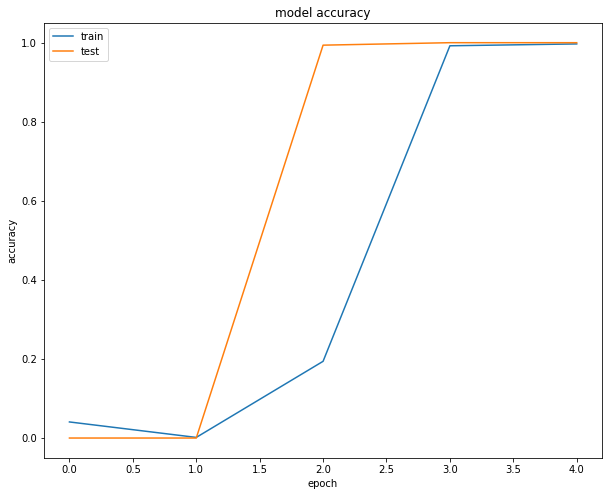

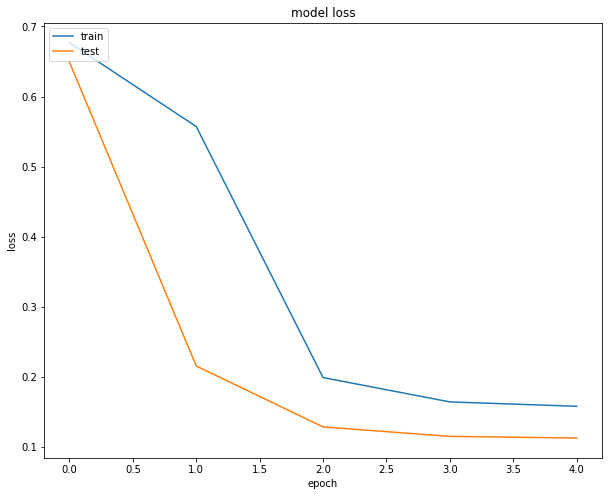

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

Since we are using small dataset, it is looks like overfitting.